# Model-based resilience metrics 

Studying possibilities for restricting initial number of results from the query TS=(resilience AND model* AND (metric OR measure* OR quant*))), with 11928 results on 5 December 2022.

In [122]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

In [123]:
df = pd.read_csv('references.csv')

In [124]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 11928 entries, 0 to 11927
Data columns (total 36 columns):
 #   Column                      Non-Null Count  Dtype  
---  ------                      --------------  -----  
 0   Unnamed: 0                  11928 non-null  int64  
 1   Publication Type            11928 non-null  object 
 2   Authors                     11927 non-null  object 
 3   Author Full Names           11927 non-null  object 
 4   Group Authors               79 non-null     object 
 5   Article Title               11928 non-null  object 
 6   Source Title                11928 non-null  object 
 7   Language                    11928 non-null  object 
 8   Document Type               11928 non-null  object 
 9   Author Keywords             10198 non-null  object 
 10  Keywords Plus               10793 non-null  object 
 11  Cited References            11901 non-null  object 
 12  Cited Reference Count       11928 non-null  int64  
 13  Times Cited, WoS Core       119

### First attempt

First possibility is removing some documents without doi, year, not in english, old or with type different from article. This does not change radically the number of results, but can make it go from 11928 to 9687.

In [125]:
count_without_DOI = df['DOI'].isnull().sum()
print('There are', count_without_DOI, 'articles without DOI.')

count_not_in_english = (df['Language'] != 'English').sum()
print('There are', count_not_in_english, 'articles not in english.')

count_without_year = df['Publication Year'].isnull().sum()
print('There are', count_without_year, 'without year.')

count_old = (df['Publication Year'] < 2000).sum()
print('There are', count_old, 'with year of publication smaller than 2000.')

count_article = (df['Document Type'].apply(lambda x: True if 'Article' in x else False)).sum()
print('There are', len(df)-count_article, 'documents that are not articles.', end=' ')
print('For example review, book chapter, proceedings, editorial.')

There are 780 articles without DOI.
There are 120 articles not in english.
There are 385 without year.
There are 102 with year of publication smaller than 2000.
There are 1602 documents that are not articles. For example review, book chapter, proceedings, editorial.


In [126]:
df['Document Type'].unique()

array(['Article', 'Review', 'Article; Early Access',
       'Article; Proceedings Paper', 'Review; Early Access',
       'Proceedings Paper', 'Article; Data Paper', 'Correction',
       'Editorial Material', 'Meeting Abstract',
       'Proceedings Paper; Retracted Publication', 'Note',
       'Review; Book Chapter', 'Letter', 'Article; Book Chapter',
       'Reprint'], dtype=object)

In [127]:
dfClean = df[df['DOI'].notnull()]
dfClean = dfClean[dfClean['Language'] == 'English']
dfClean = dfClean[dfClean['Publication Year'].notnull()]
dfClean = dfClean[dfClean['Publication Year'] >= 2000]
dfClean = dfClean[dfClean['Document Type'].apply(lambda x: True if 'Article' in x else False)]

print('The number of results go from', len(df), 'to', len(dfClean), 'with these removals (', len(df)-len(dfClean), ')')

The number of results go from 11928 to 9614 with these removals ( 2314 )


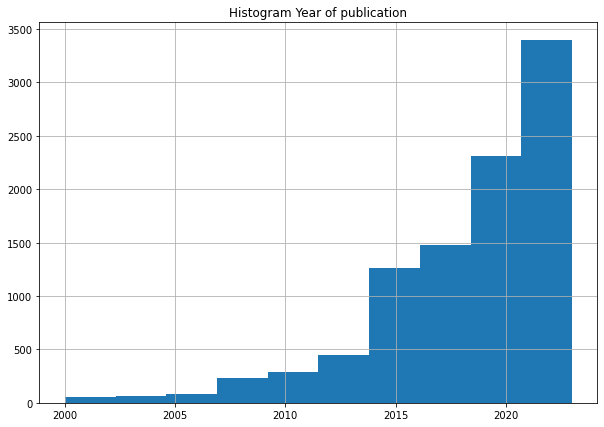

In [128]:
plt.figure(figsize=(10, 7))
plt.hist(dfClean['Publication Year'], bins=10)
#plt.xticks(np.arange(0, 100, step=5)) 
plt.title('Histogram Year of publication')
plt.grid()
plt.show()

### Second attempt

A second possibility is removing documents with few citations.

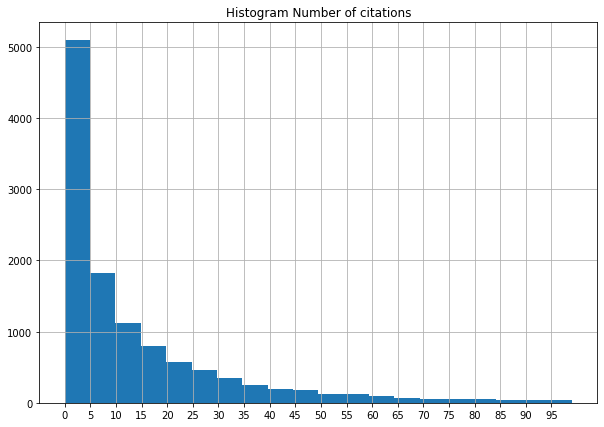

(-0.1, 4.95]     5090
(4.95, 9.9]      1823
(9.9, 14.85]     1127
(14.85, 19.8]     794
(19.8, 24.75]     567
(24.75, 29.7]     467
(29.7, 34.65]     343
(34.65, 39.6]     255
(39.6, 44.55]     190
(44.55, 49.5]     180
(49.5, 54.45]     129
(54.45, 59.4]     120
(59.4, 64.35]      90
(64.35, 69.3]      72
(74.25, 79.2]      58
(69.3, 74.25]      56
(79.2, 84.15]      50
(84.15, 89.1]      42
(94.05, 99.0]      41
(89.1, 94.05]      36
Name: Times Cited, All Databases, dtype: int64
More than  100 citations 390


In [130]:
cut_line = 100
bins = 20

plt.figure(figsize=(10, 7))
plt.hist(df[df['Times Cited, All Databases'] < cut_line]['Times Cited, All Databases'], bins=bins)
#df[df['Times Cited, All Databases'] < cut_line].hist(column='Times Cited, All Databases', bins=bins)
plt.xticks(np.arange(0, 100, step=5)) 
plt.grid()
plt.title('Histogram Number of citations')
plt.show()

print(df[df['Times Cited, All Databases'] < cut_line]['Times Cited, All Databases'].value_counts(bins=bins))
print('More than ', cut_line, 'citations', (df['Times Cited, All Databases'] > cut_line).sum())

In [85]:
count_few_5_citation = (df['Times Cited, All Databases'] < 5).sum()
count_few_10_citation = (df['Times Cited, All Databases'] < 10).sum()
print('There are', count_few_5_citation, 'articles with number of citations smaller than 5.')
print('There are', count_few_10_citation, 'articles with number of citations smaller than 10.')

dfNew1 = dfClean[dfClean['Times Cited, All Databases'] >= 5]
dfNew2 = dfClean[dfClean['Times Cited, All Databases'] >= 10]
print('The number of results go from', len(dfClean), 'to', len(dfNew1), 'when considering only', end=' ')
print('greater than 5, and to', len(dfNew2), 'when considering only greater than 10.')

There are 5090 articles with number of citations smaller than 5.
There are 6913 articles with number of citations smaller than 10.
The number of results go from 9614 to 6041 when considering only greater than 5, and to 4452 when considering only greater than 10.


In [86]:
(4452*3)/(60*8)

27.825

With 4452 documents I would take approximately 28 days to read all abstracts, considering 3 min per paper.

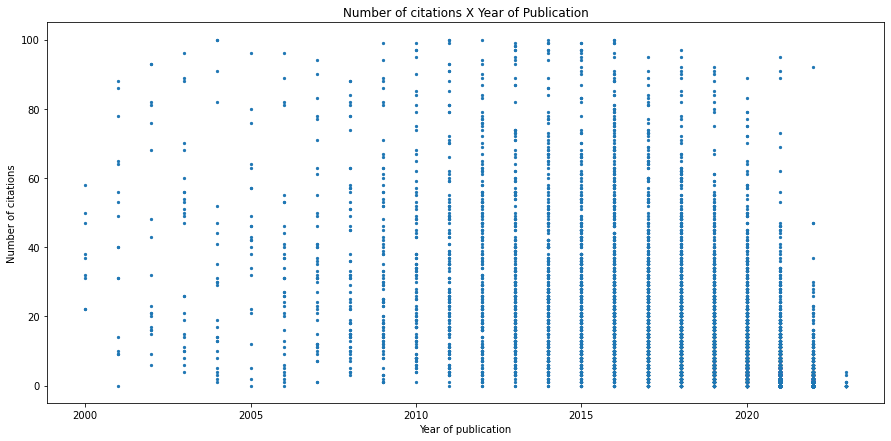

In [133]:
plt.figure(figsize=(15, 7))
dfNew3 = dfClean[dfClean['Times Cited, All Databases'] <= 100]
plt.scatter(dfNew3['Publication Year'], dfNew3['Times Cited, All Databases'], s=5)
plt.title('Number of citations X Year of Publication')
plt.xlabel('Year of publication')
plt.ylabel('Number of citations')
plt.show()

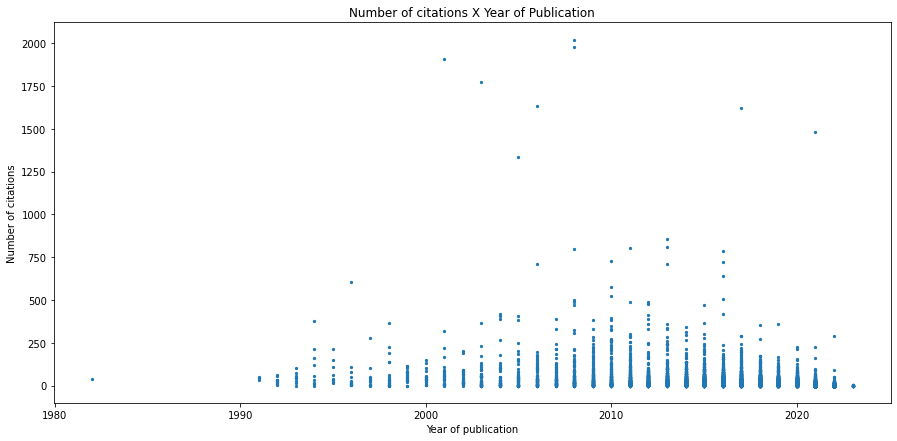

In [134]:
plt.figure(figsize=(15, 7))
plt.scatter(df['Publication Year'], df['Times Cited, All Databases'], s=5)
plt.title('Number of citations X Year of Publication')
plt.xlabel('Year of publication')
plt.ylabel('Number of citations')
plt.show()